# Import packages and aux functions

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import preprocessing, plotting
sns.set(style='darkgrid')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import (cross_validate, cross_val_predict,cross_val_score, train_test_split,
                                     GridSearchCV, RandomizedSearchCV, StratifiedKFold, RandomizedSearchCV)
from pprint import pprint


In [2]:
def get_sorted_feat_importance(importance, feature_names):
    feature_importance = np.array(importance)
    feature_names = np.array(feature_names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df['cum_sum_fi']=fi_df['feature_importance'].cumsum()
    return fi_df

# Load Data

In [3]:
# data loading
questions = pd.read_csv('data/question_data.csv', sep=';')
questions = questions.set_index('Unnamed: 0')  # set first column (question number) as index
questions.index.rename('q_id', inplace=True)
#questions.loc['gender', ['text', 'Keywords']] = ['gender?', 'descriptive'] # include gender as descriptive question

descriptive_questions = questions[questions['Keywords']=='descriptive'].index.to_list()
question_to_id = {question_id:i for i, question_id in enumerate(descriptive_questions)}
descriptive_questions = list(question_to_id.values())
questions.rename(index=question_to_id, inplace=True)
display(questions.loc[descriptive_questions].head())


,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
0,Which word describes you better?,Carefree,Intense,NaN,NaN,49827,N,NaN,descriptive
1,Have you ever seen a therapist?,Yes,No,NaN,NaN,9507,O,NaN,descriptive
2,Which describes you better?,Warm-hearted,Cool-headed,NaN,NaN,21205,O,NaN,descriptive
3,Are you a better conversationalist or listener?,Conversationalist,Listener,NaN,NaN,3174,O,NaN,descriptive
4,Which word describes you better?,Private,Social,NaN,NaN,23765,O,NaN,descriptive


In [4]:
data = pd.read_parquet('data/train.parquet')
political_belief = 'q212813'
data.rename({'q212813': 'political_belief', 'Unnamed: 0': 'user_id',**question_to_id}, axis=1, inplace=True)

# per question count number of times the question is answered
n_answers_per_question = data.loc[:, descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index
question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

features_df = data[descriptive_questions]
print('Nr of rows, nr of descriptive questions', features_df.shape)

,text
789,Which type of wine would you prefer to drink o...
823,Do you like watching foreign movies with subti...
821,Do you enjoy intense intellectual conversations?
109,Have you smoked a cigarette in the last 6 months?
8,How frequently do you drink alcohol?
305,Rate your self-confidence:
373,How often do you keep your promises?
420,How often are you open with your feelings?
10,What's your deal with harder drugs (stuff beyo...
141,Are you happy with your life?


Nr of rows, nr of descriptive questions (36085, 829)


In [5]:
df_trn, df_val = train_test_split(data[descriptive_questions+ ['political_belief', 'gender', 'd_age']], test_size=0.1, random_state=1)
df_val = df_val[descriptive_questions+['political_belief']]

# Create a dataframe with the top k questions, that all subject answered

To keep the train set reasonably big, we compute, how many questions we can include, s.t. that the nr. of subjects who answered these questions is at least 10.000. 

In [6]:
K=200
subset_size_topk = [features_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [ ]:
# biggest k with >10.000 subjects who answered ALL k questions
min_train_size = np.arange(10, 25)*1000
n_most_answered = [next(x[0] for x in enumerate(subset_size_topk) if x[1] < min_set_size) for min_set_size in min_train_size]
n_most_answered

[49, 42, 37, 33, 28, 26, 24, 22, 19, 19, 18, 16, 15, 13, 12]

In [ ]:
print(f'Shape of validation set before: {df_val.shape}')
top_questions = sorted_questions[:np.max(n_most_answered)].to_list()
df_val = df_val[top_questions+['political_belief']].dropna() 
print(f'Shape of validation set after selecting the top {np.max(n_most_answered)} questions: {df_val.shape}')

X_val = df_val[top_questions]
y_val = df_val[['political_belief']]

Shape of validation set before: (987, 50)
Shape of validation set after selecting the top 49 questions: (987, 50)


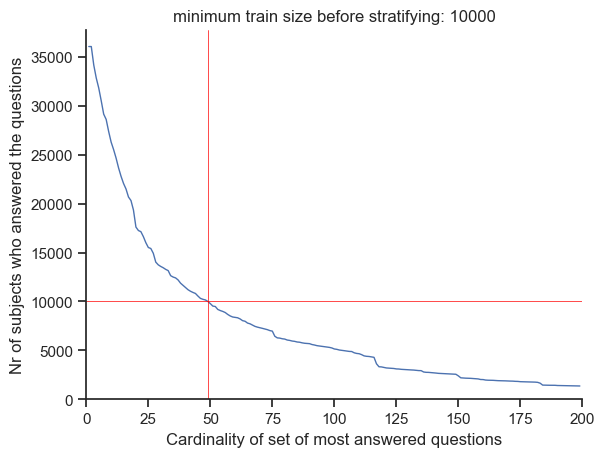

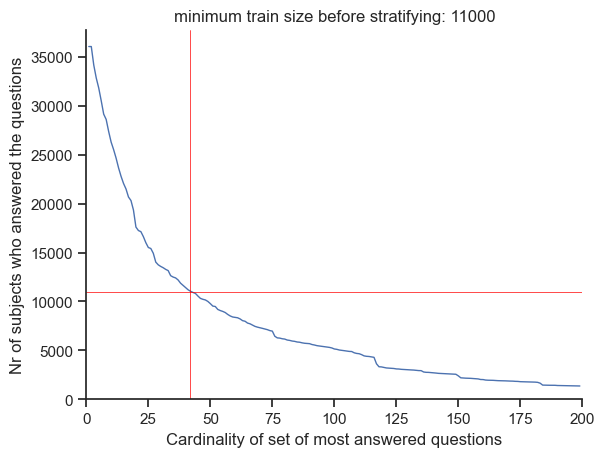

In [ ]:
for n, min_size in zip(n_most_answered[:2], min_train_size):
    sns.set_style("white")
    sns.set_style("ticks")
    g = sns.lineplot(x = range(1,K), y = subset_size_topk, linewidth=1)
    g.axhline(y=min_size, color='red', linewidth=0.5)
    g.axvline(x=n, color='red', linewidth=0.5)

    plt.xlim(0, 200)
    plt.ylim(0)
    sns.despine()
    #plt.ylim(0,len(features_df))
    g.set(xlabel ="Cardinality of set of most answered questions", ylabel = "Nr of subjects who answered the questions")
    #title ='Nr of subjects who answered the same k most anwered questions '
    #plt.figtext(0.5, -0.1, 'Grouping most answered questions into a set, comparing the number of questions in the set to the number of subjects who answered all questions in the set', wrap=True, horizontalalignment='center', fontsize=12)
    plt.title(f'minimum train size before stratifying: {min_size}')
    plt.show()

## HPO: Optimize Ratio: (Nr of feature)/(Train set size)

In [101]:
val_scores = []

for n in n_most_answered:
    top_questions = sorted_questions[:n].to_list()
    filter_by = top_questions + ['political_belief']
    stratified_df = df_trn[filter_by].dropna()
    n_conservative = stratified_df.groupby('political_belief').count().iloc[1, 0]
    stratified_df = stratified_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))


    # split into features and target
    features_df_strat = stratified_df[top_questions]
    target = stratified_df.loc[features_df_strat.index][['political_belief']]

    # encode train and validation set
    feature_encoder = OrdinalEncoder()
    target_encoder = LabelEncoder()
    # train set
    X_train_encoded = feature_encoder.fit_transform(features_df_strat)
    y_train_encoded = target_encoder.fit_transform(target.values.ravel())
    # val set
    X_val_encoded = feature_encoder.transform(X_val[top_questions])
    y_val_encoded = target_encoder.transform(y_val.values.ravel())

    # Naive Bayes Hyper parameter Tuning
    nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
    preds = nb.predict(X_val_encoded)
    val_scores.append(balanced_accuracy_score(y_val_encoded, preds))

best_nr_of_questions = n_most_answered[np.argmax(val_scores)]
print(f'Best balanced accuracy on the validation set obtained with {best_nr_of_questions} number of answered questions')

Best balanced accuracy on the validation set obtained with 19 number of answered questions


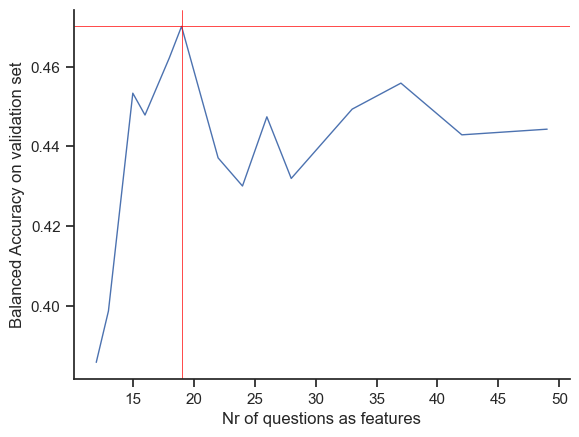

In [102]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = n_most_answered, y = val_scores, linewidth=1)
g.axhline(y=np.max(val_scores), color='red', linewidth=0.5)
g.axvline(x=best_nr_of_questions, color='red', linewidth=0.5)
sns.despine()
g.set(ylabel ='Balanced Accuracy Score', xlabel ='Nr of questions as features', title='Evaluation on validation set')
plt.show()

# Stratification

In [104]:
top_questions = sorted_questions[:best_nr_of_questions].to_list()
filter_by = top_questions + ['political_belief']
stratified_df = data[filter_by].dropna()
n_conservative = stratified_df.groupby('political_belief').count().iloc[1, 0]
stratified_df = stratified_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))
display(stratified_df.head())

,789,823,821,109,8,305,373,420,10,141,9,0,268,198,818,331,500,296,299,political_belief
index,,,,,,,,,,,,,,,,,,,,
29116,"White (such as Chardonnay, Riesling).",No,Yes,No,Sometimes,"Very, very high",Whenever possible,Usually,I never do drugs.,Yes,Never.,Intense,Knowledge,Twice or more a day,A little important,No,I am my own person.,Yes,Rarely / never,Centrist
34449,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Yes,No,Sometimes,Average,Whenever possible,Always,I never do drugs.,No,Never.,Intense,Expression,Twice or more a day,A little important,Yes,I am my own person.,Sometimes,Sometimes,Centrist
66159,"Red (such as Merlot, Cabernet, Shiraz).",Can't answer without a subtitle,Yes,No,Sometimes,Higher than average,Whenever possible,Rarely,I never do drugs.,Yes,"I smoked in the past, but no longer.",Carefree,Love,Twice or more a day,Somewhat important,No,I consider their opinion but go my own way.,Yes,Rarely / never,Centrist
32054,I don't drink wine.,Can't answer without a subtitle,Yes,No,Never,Average,Whenever possible,Usually,I never do drugs.,Yes,Never.,Carefree,Love,Twice or more a day,Very important,No,I am my own person.,Sometimes,All the time,Centrist
51912,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Yes,Yes,Sometimes,Average,Whenever possible,Rarely,I never do drugs.,Yes,I smoke occasionally.,Carefree,Love,Twice or more a day,A little important,No,I consider their opinion but go my own way.,Sometimes,Sometimes,Centrist


# Question distribution

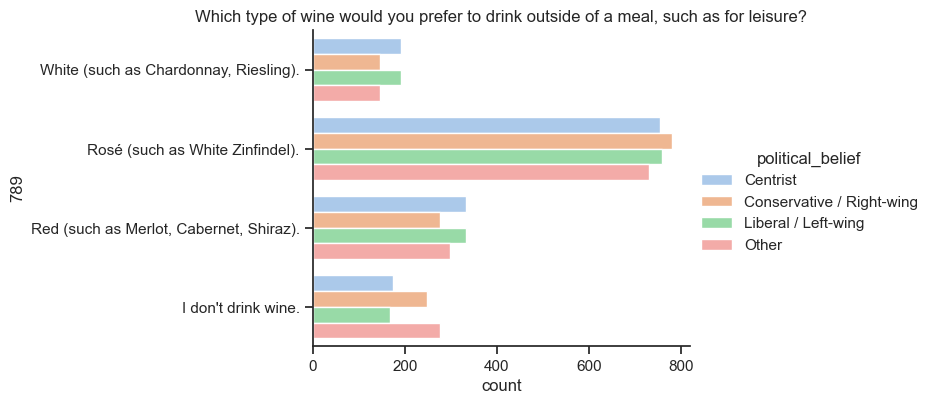

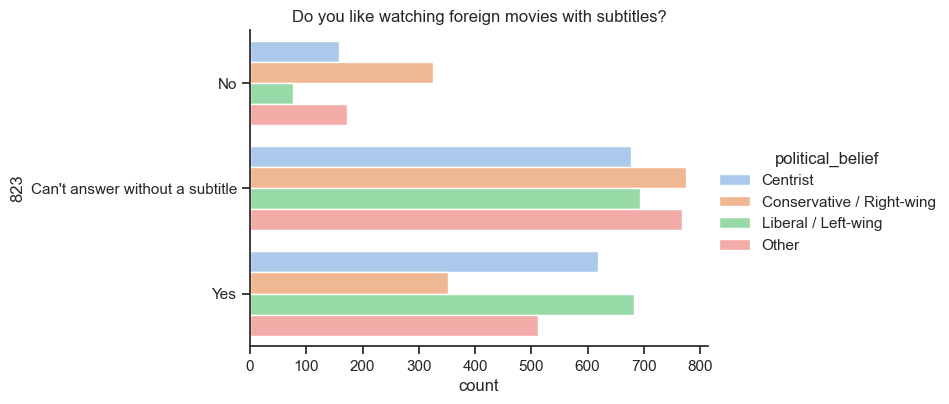

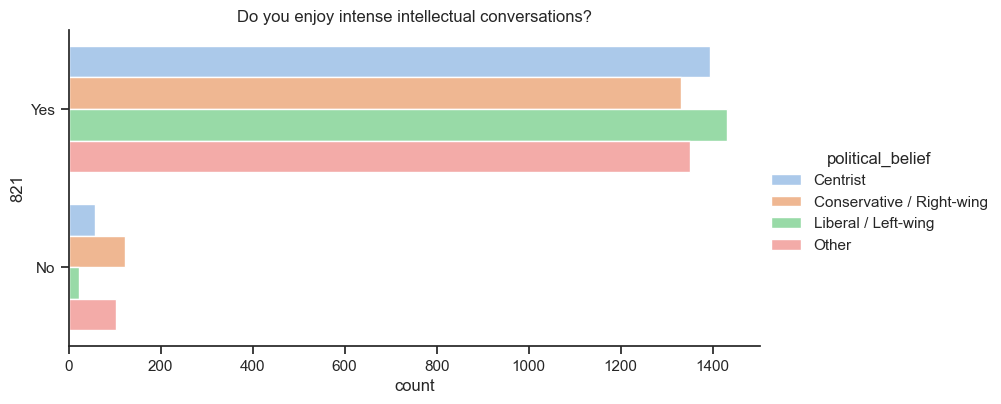

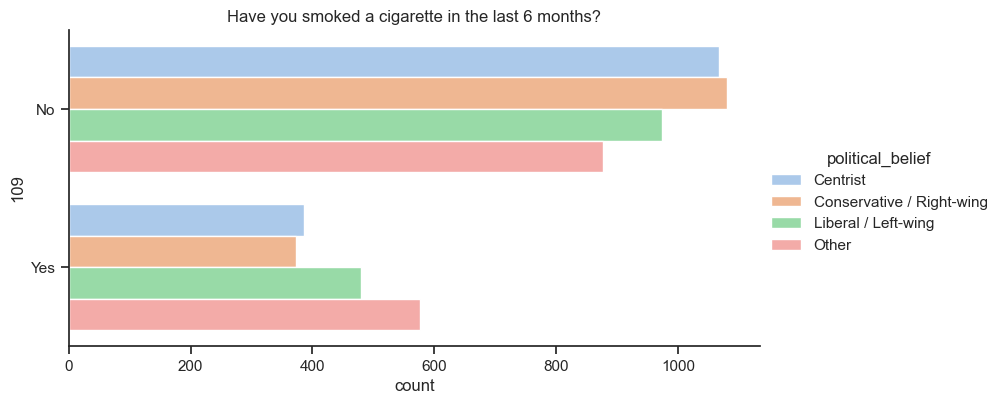

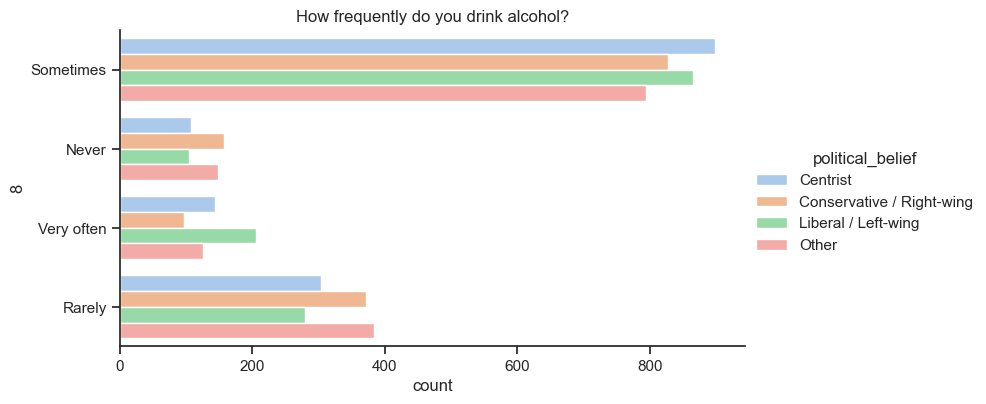

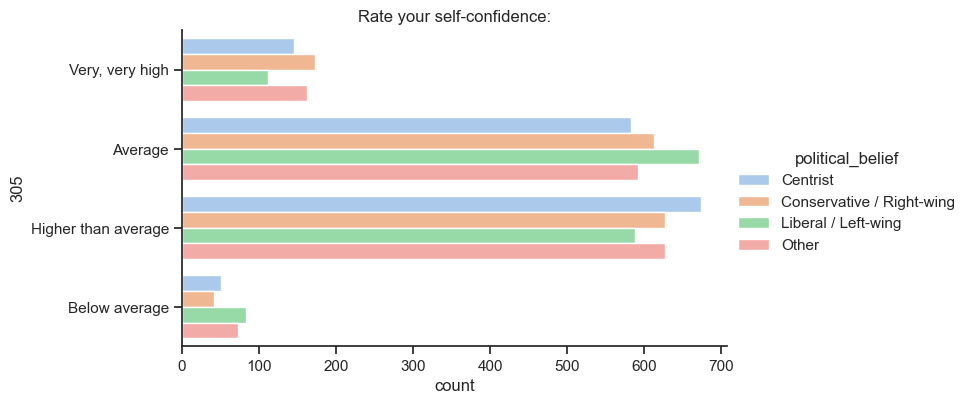

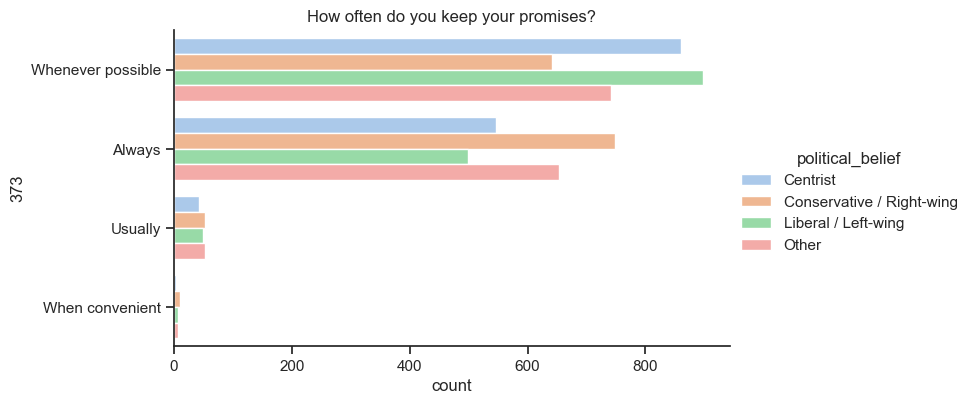

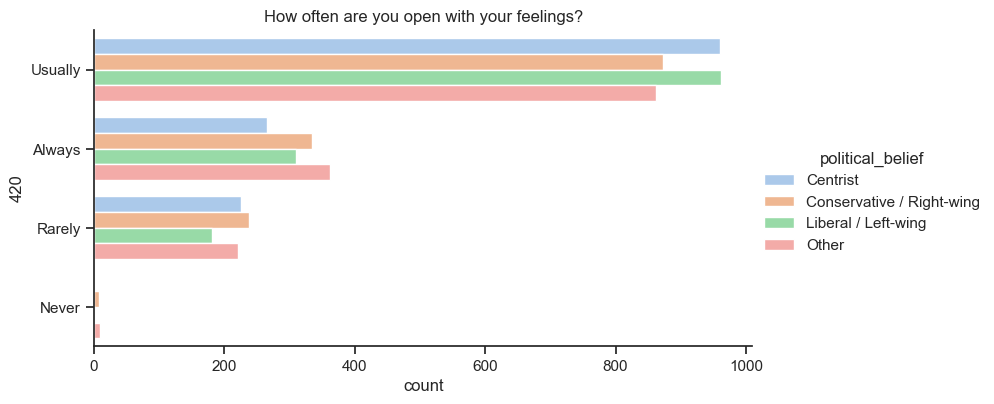

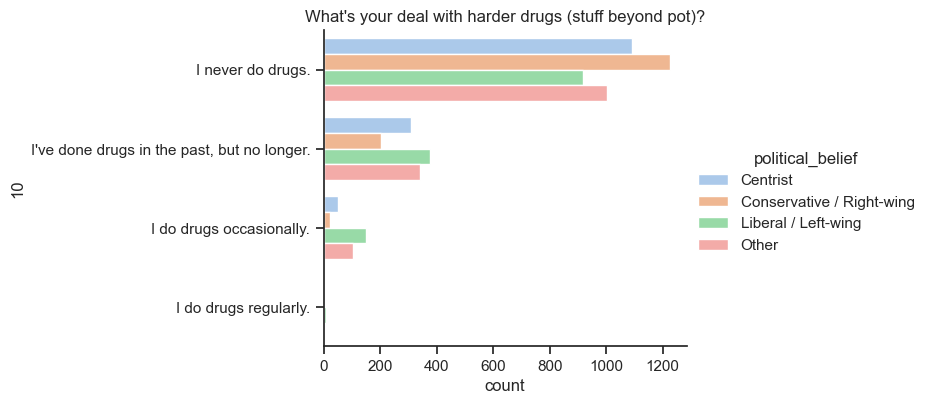

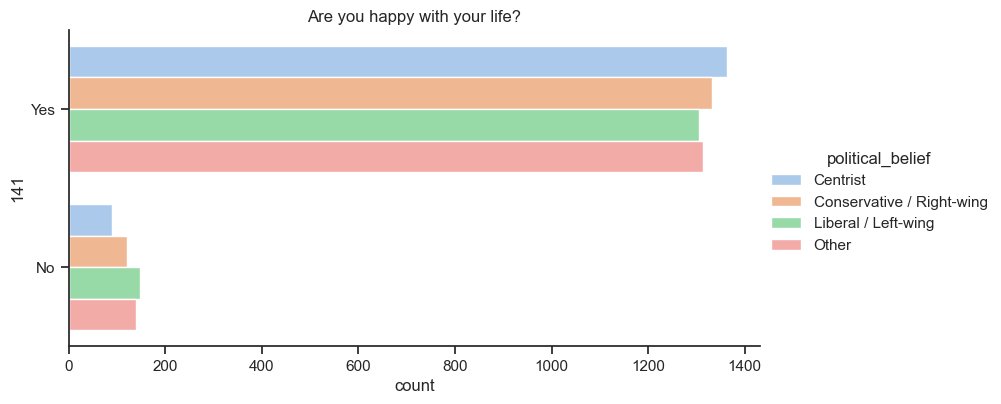

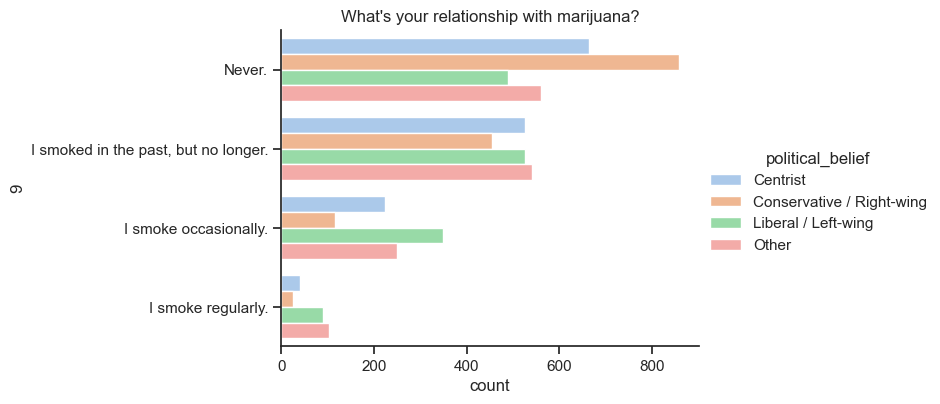

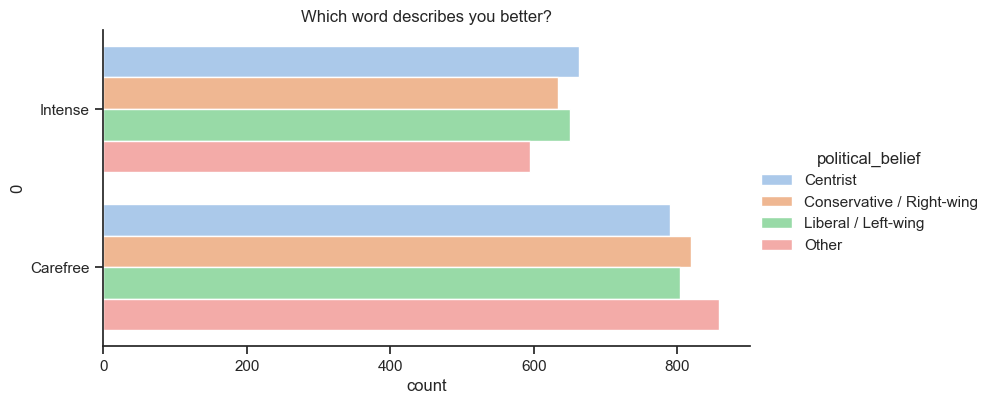

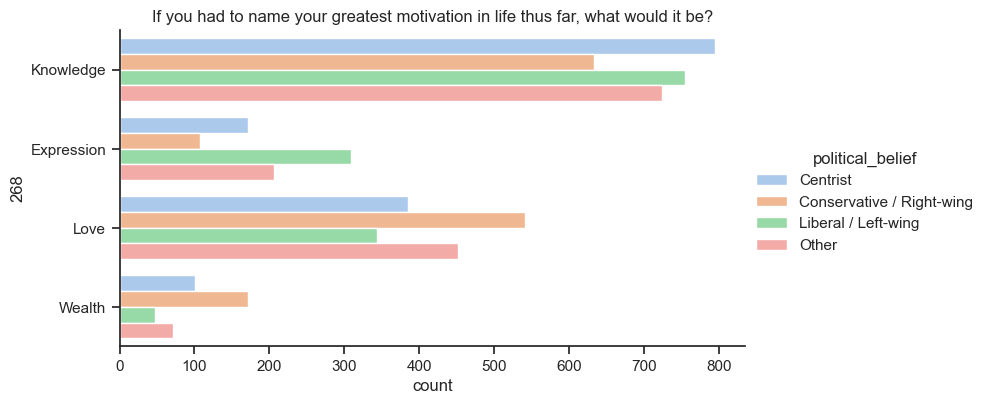

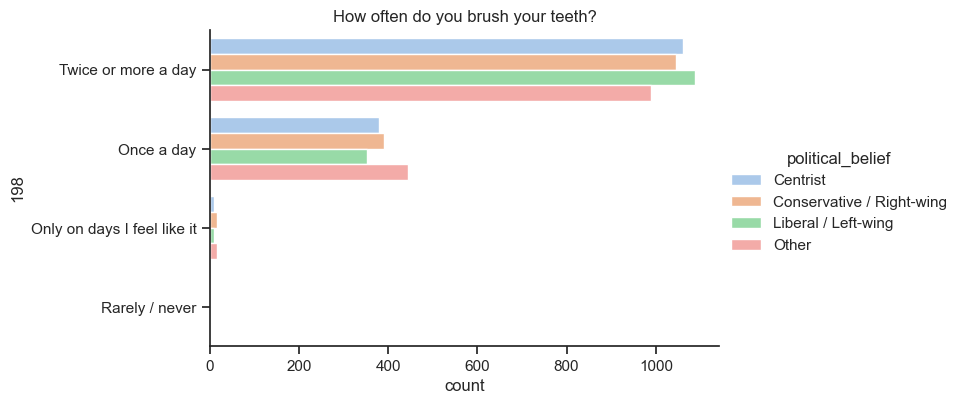

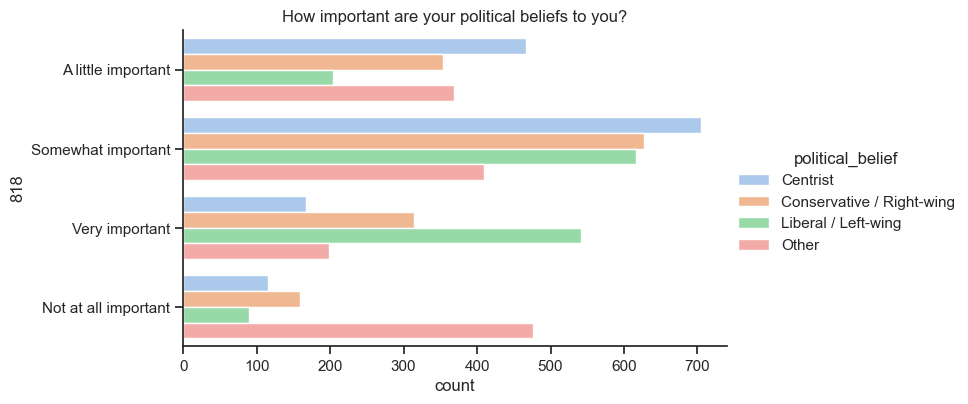

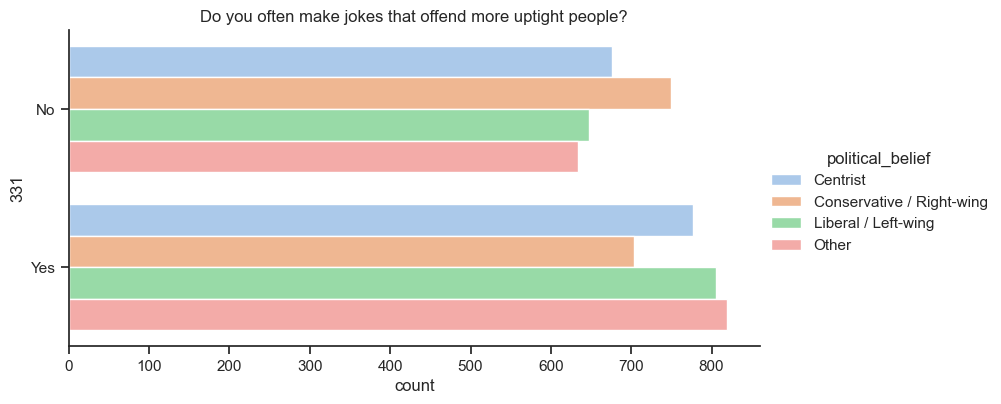

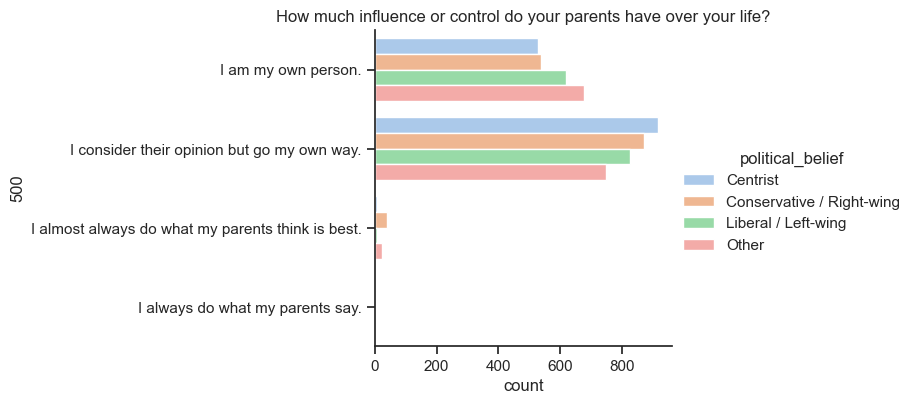

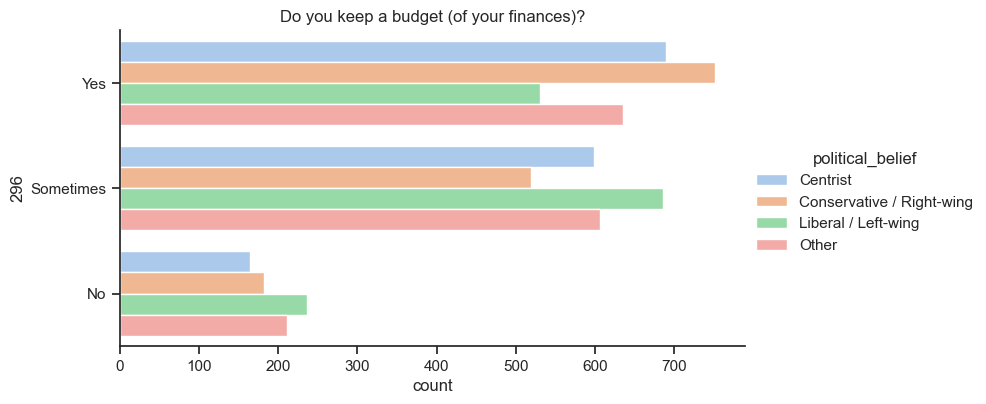

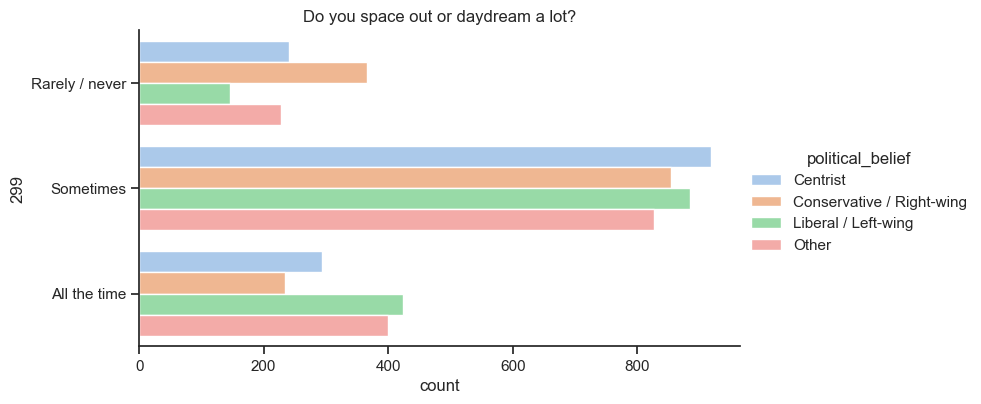

In [105]:
def plot_question_distribution(question: str, data: pd.DataFrame, questions: pd.DataFrame):
    """plots histogram of polical orientation for a given question"""
    title = questions.loc[question, 'text']
    sns.catplot(
        data=data, y=question, kind="count", hue='political_belief', palette="pastel", aspect=2, height = 4).set(title=title)

for question in top_questions:
    plot_question_distribution(question, stratified_df, questions)

# Feature Encoding 

In [114]:
# split into features and target
features_df = stratified_df[top_questions]
target = stratified_df.loc[features_df.index][['political_belief']]

In [115]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df)
y_train_encoded = target_encoder.fit_transform(target.values.ravel())

# Baseline Model: Naive Bayes

In [116]:
# Naive Bayes Hyper parameter Tuning
nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
scores = cross_val_score(nb, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.44 accuracy with a standard deviation of 0.01


# Random Forest Classifier
## Hyperparameter Tuning
HPT using Random Search with stratified K-fold crossvalidation \
Chosen scoring metrics: balanced accuracy (average of recall obtained on each class)

In [110]:
# Choose parameter distributions
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(param_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_random = RandomizedSearchCV(estimator = rf,
                             param_distributions = param_grid, 
                             n_iter = 100, 
                             cv = 3, 
                             verbose=2, 
                             random_state=42, 
                             n_jobs = -1, 
                             scoring='balanced_accuracy')
rf_random.fit(X_train_encoded, y_train_encoded)

In [118]:
print('Results of parameter tuning with random search:')
best_random_params={'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1000}
 #rf_random.best_params_
pprint(best_random_params)

Results of parameter tuning with random search:
{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1000}


In [ ]:
# rf_tuned = RandomForestClassifier(**best_random_params).fit(X_train_encoded, y_train_encoded)
# scores = cross_val_score(rf_tuned, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
# print("%0.2f Balanced accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

rf_tuned = rf_random.best_estimator_
scores = cross_val_score(rf_tuned, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Visualize (gini) feature importance and the cumultative sum

In [166]:
fi_df = get_sorted_feat_importance(rf_tuned.feature_importances_, features_df.columns)
print('Top 20 Features sorted by their gini impotance scores ')
for i, row in fi_df[:20].iterrows():
    print(f"Feature {row['feature_names']}: {questions.loc[row['feature_names']].text}: {row['feature_importance']}")

Top 20 Features sorted by their gini impotance scores 
Feature 818: How important are your political beliefs to you?: 0.19488302437106203
Feature 9: What's your relationship with marijuana?: 0.07768277811259242
Feature 268: If you had to name your greatest motivation in life thus far, what would it be?: 0.0741637259327218
Feature 823: Do you like watching foreign movies with subtitles?: 0.07100937772939264
Feature 789: Which type of wine would you prefer to drink outside of a meal, such as for leisure?: 0.054980454847437216
Feature 305: Rate your self-confidence:: 0.0529799631608327
Feature 8: How frequently do you drink alcohol?: 0.05148053207677599
Feature 299: Do you space out or daydream a lot?: 0.0497214702634437
Feature 373: How often do you keep your promises?: 0.04836623151467842
Feature 296: Do you keep a budget (of your finances)?: 0.04703919849761772
Feature 420: How often are you open with your feelings?: 0.04633141605248662
Feature 10: What's your deal with harder drugs (s

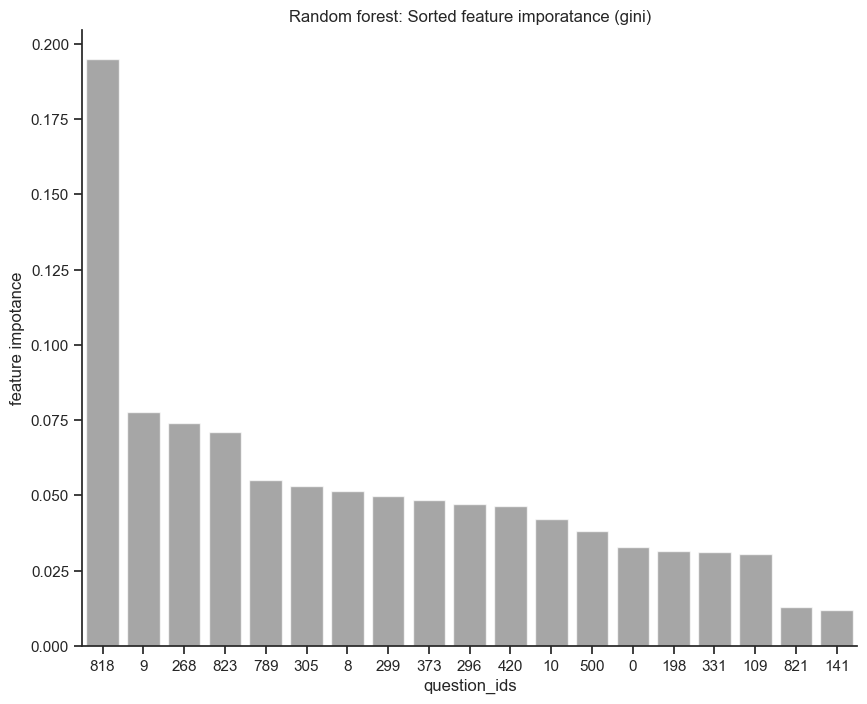

In [167]:
#Define size of bar plot
plt.figure(figsize=(10,8))
sns.set_style("white")
sns.set_style("ticks")
#Plot Searborn bar chart
g = sns.barplot(y=fi_df['feature_importance'].values, x=np.arange(len(fi_df.index)), color='gray', alpha=0.7)
sns.despine()

g.set_xticklabels(fi_df['feature_names'])
#Add chart labels
g.set_title('Random forest: Sorted feature imporatance (gini)')
g.set(ylabel ='feature impotance', xlabel ='question_ids')
plt.show()

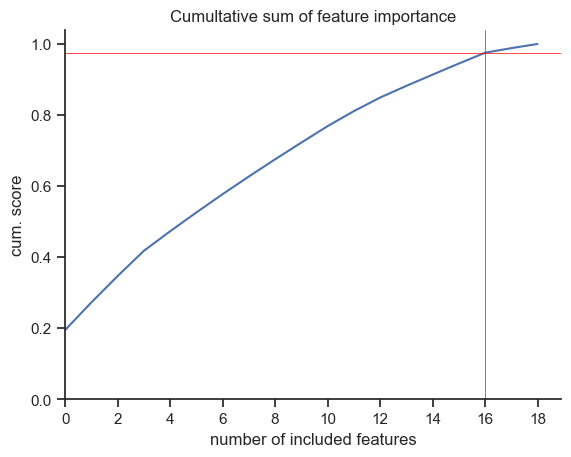

In [168]:
# first top k question, s.t. Cumultative sum of feature importance is >=.95
cum_sum_top_k = next(x[0] for x in enumerate(fi_df.cum_sum_fi) if x[1] >=0.95)

sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = np.arange(len(fi_df)), y = fi_df['cum_sum_fi'])
g.axhline(y=fi_df['cum_sum_fi'].iloc[cum_sum_top_k], color='red', linewidth=0.5)
g.axvline(x=cum_sum_top_k, color='red', linewidth=0.5)
sns.despine()
plt.ylim(0)
plt.xlim(0)
g.set(xlabel='number of included features', ylabel='cum. score', title='Cumultative sum of feature importance', xticks=np.arange(len(fi_df), step=2))
plt.show()

# Evaluation

In [111]:
# Naive Bayes
clf = CategoricalNB(fit_prior=False)
y_pred = cross_val_predict(clf, X_train_best_feat, y_train_encoded, cv=10)
conf_mat = confusion_matrix(y_train_encoded, y_pred)
crossval_accuracy = accuracy_score(y_train_encoded, y_pred)
f1_score = f1_score(y_train_encoded, y_pred, average='weighted')
recall_score = recall_score(y_train_encoded, y_pred, average='weighted')
print('crossval accuracy', crossval_accuracy)
print('f1 ', f1_score)
print('recall ', recall_score)
print(conf_mat)


crossval accuracy 0.3752034725990233
f1  0.36165498623542586
recall  0.3752034725990233
[[ 518  650  453  222]
 [ 346 1020  225  252]
 [ 355  413  869  206]
 [ 320  660  504  359]]


### To-Dos:
- Data Distribution 
- Cross Validation for the 3 best model configurations
- Compute Confustion Matrix and other evaluations
- Decide which classifier to use
- Significance test
- Random features: scramble targets --> significance test

### Questions for Auguste:
- One-hot passt?
- Reicht balanced bei model? -> nicht features angepasst
- Signifance test?

# Data Distributions

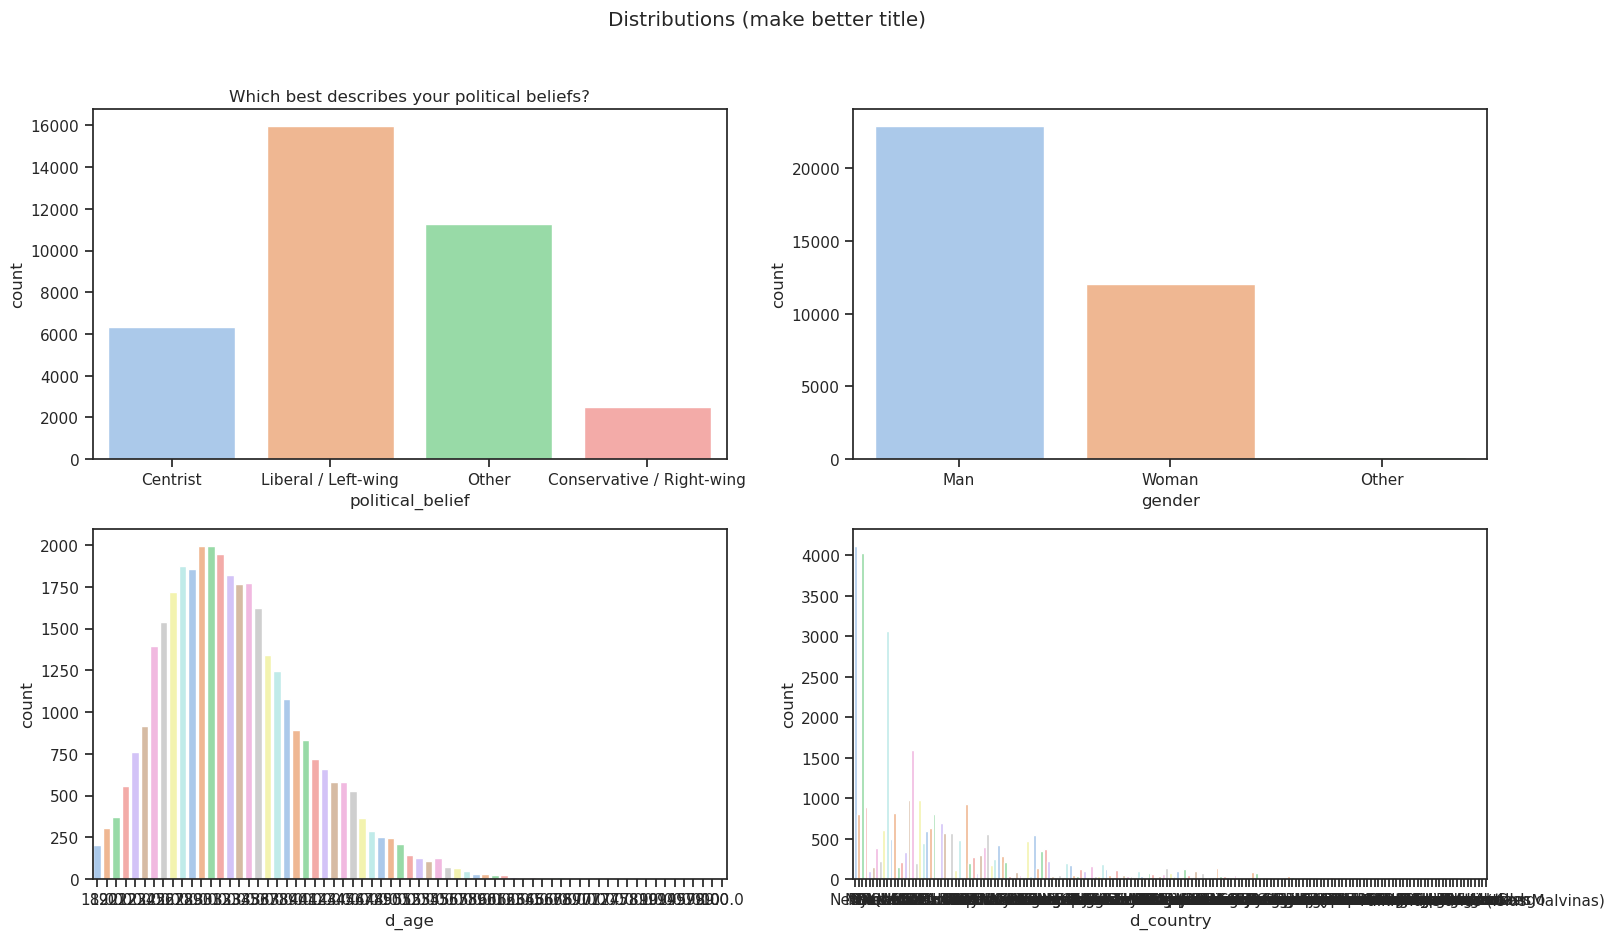

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Distributions (make better title)')

 
sns.countplot(ax=axes[0, 0], data=data, x='political_belief', palette="pastel").set(title=questions.loc['q212813', 'text'])
sns.countplot(ax=axes[0, 1], data=data, x='gender', palette="pastel")
sns.countplot(ax=axes[1, 0], data=data, x='d_age', palette="pastel")
sns.countplot(ax=axes[1, 1], data=data, x='d_country', palette="pastel")
plt.show()

In [ ]:
descriptive_questions = [column for column in data.columns if column.startswith('q')]
data['n_q_answered'] = data[descriptive_questions].count(axis=1)

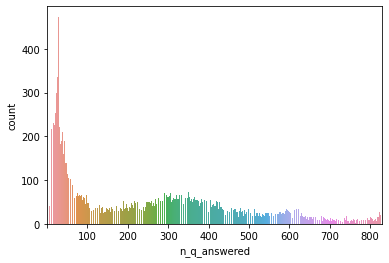

In [ ]:
ax = sns.countplot(x=data['n_q_answered'])
ax.set_xticks(range(-2, data['n_q_answered'].max(), 100))
plt.show()